In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pytesseract    


In [15]:
img = cv2.imread("./data/Car License Plate Detection/images/Cars14.png")
img

array([[[180, 198, 220],
        [180, 198, 220],
        [179, 197, 220],
        ...,
        [253, 230, 239],
        [254, 230, 239],
        [253, 230, 239]],

       [[179, 198, 220],
        [179, 198, 220],
        [178, 197, 219],
        ...,
        [254, 230, 239],
        [254, 230, 239],
        [254, 230, 239]],

       [[177, 195, 217],
        [177, 195, 217],
        [175, 194, 215],
        ...,
        [253, 230, 240],
        [254, 230, 240],
        [253, 230, 239]],

       ...,

       [[ 17,  18,  25],
        [ 17,  17,  24],
        [ 17,  18,  25],
        ...,
        [  8,   9,   8],
        [  7,   9,   7],
        [  7,   9,   7]],

       [[ 13,  13,  14],
        [ 13,  13,  14],
        [ 13,  13,  16],
        ...,
        [  6,   6,   4],
        [  8,   8,   6],
        [  9,   9,   7]],

       [[ 11,  11,  10],
        [ 11,  11,  10],
        [ 11,  11,   9],
        ...,
        [  8,   9,   7],
        [ 10,  10,   9],
        [ 11,  11,   9]]

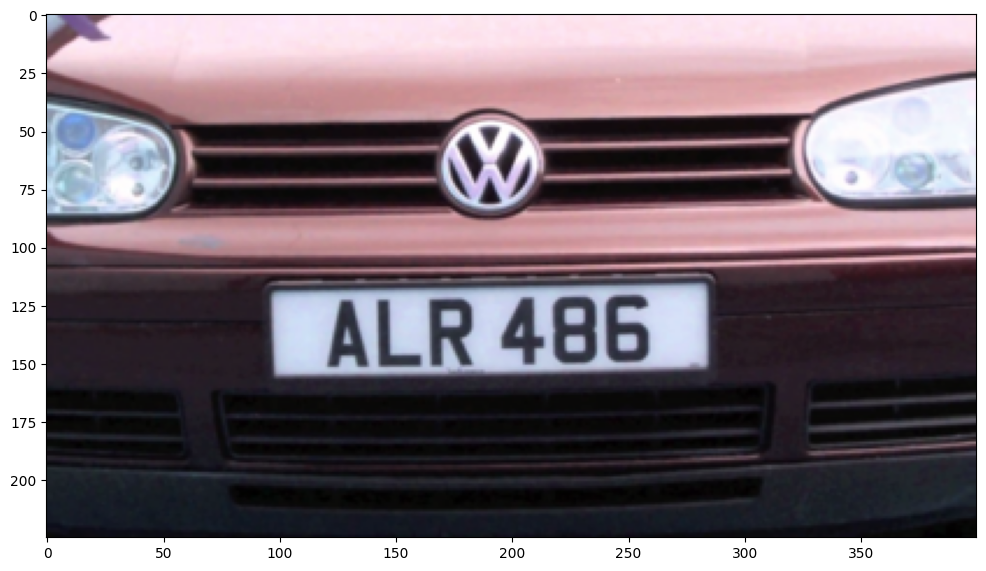

In [17]:
height, width, channel = img.shape

plt.figure(figsize=(12, 10))
plt.imshow(img, cmap='gray')
plt.axis('on')
plt.savefig('saved/Car.png',bbox_inches = 'tight')
plt.show()

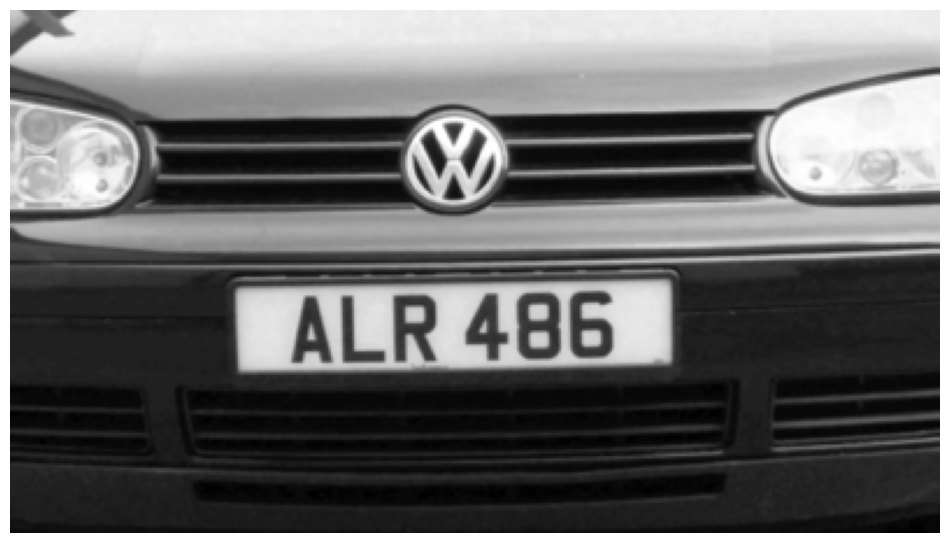

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

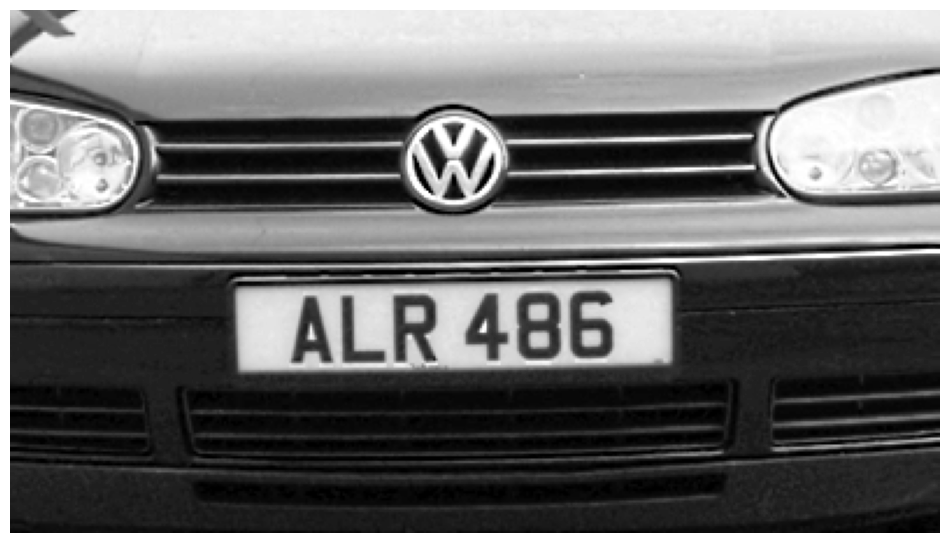

In [19]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))   

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement) 
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)          
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)   

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-Contrast.png',bbox_inches = 'tight')
plt.show()

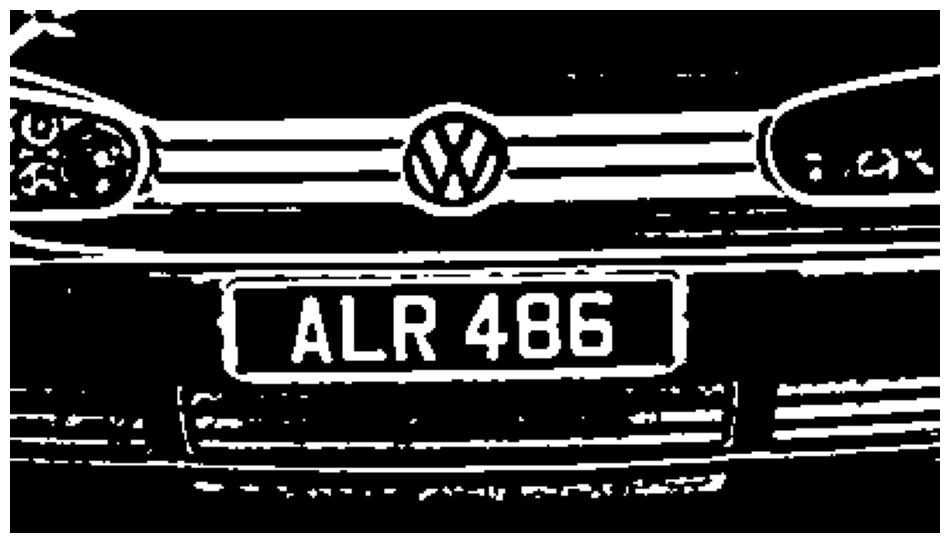

In [20]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) 

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,    
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

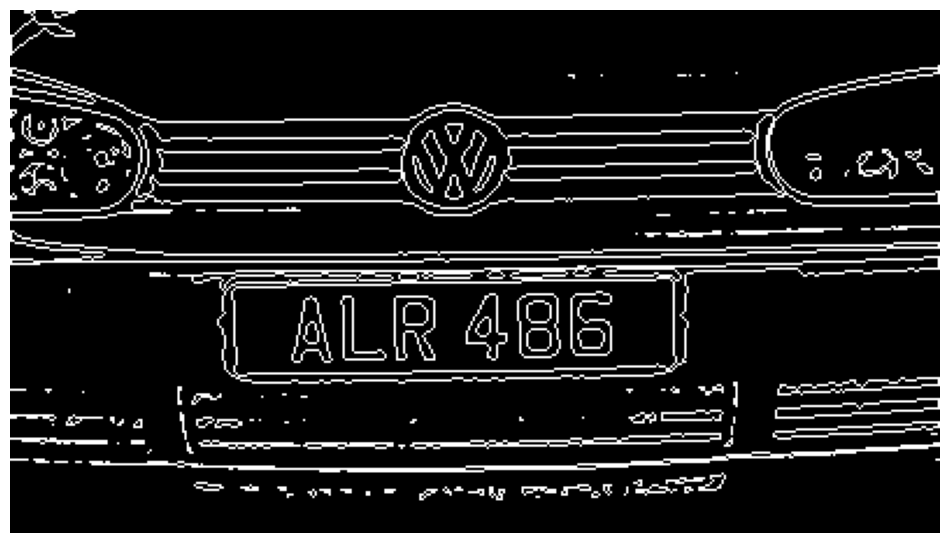

In [21]:
contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('saved/Car-Contours.png',bbox_inches = 'tight')
plt.show()

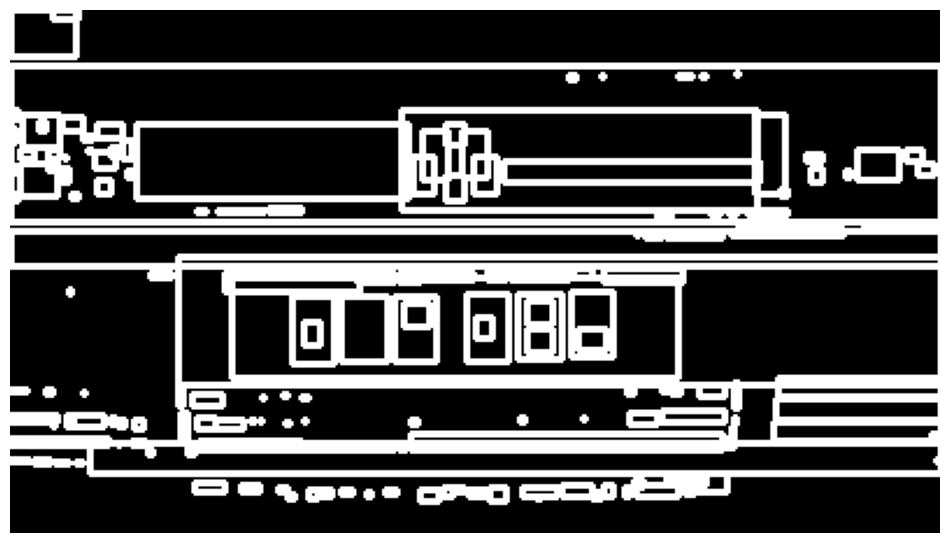

In [22]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-Boxes.png',bbox_inches = 'tight')
plt.show()

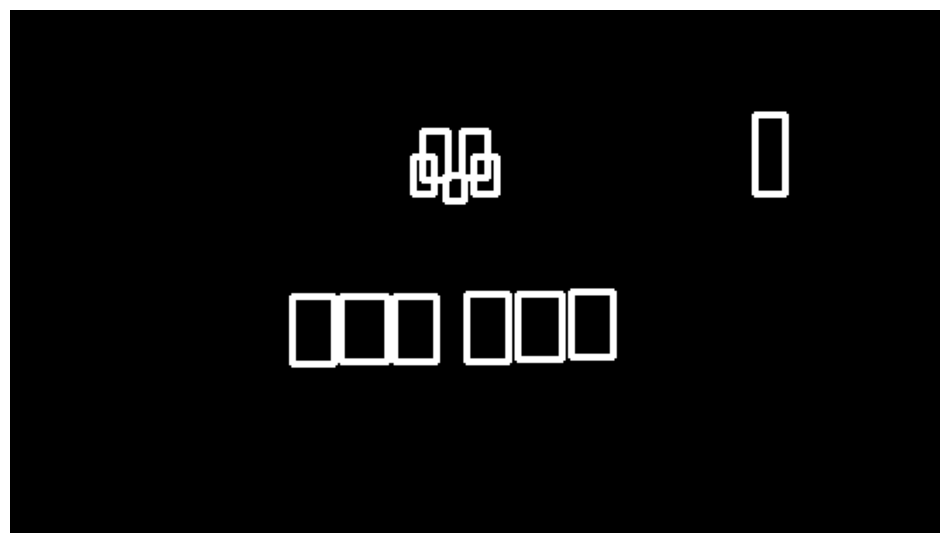

In [24]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()

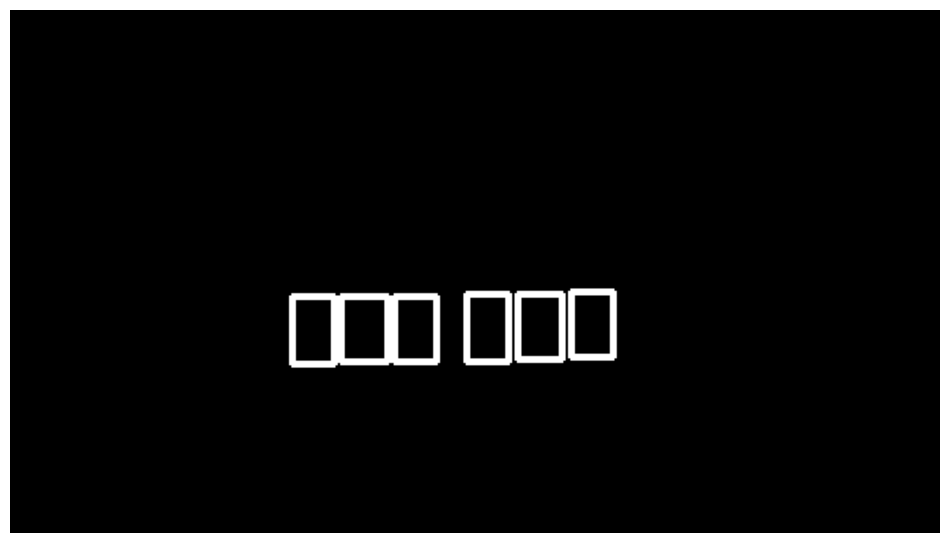

In [25]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

# Overlaying the found number plate boxes onto the original image:

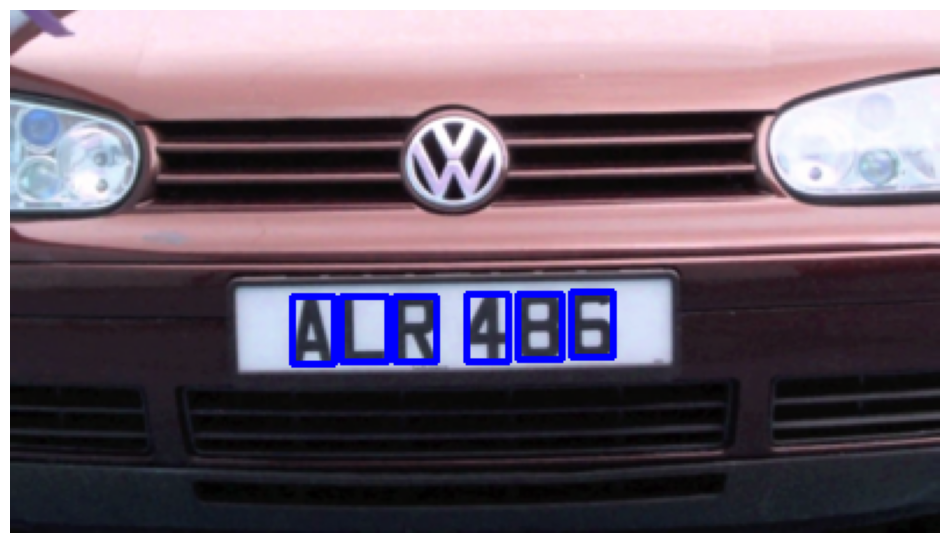

In [27]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('saved/Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()